# Cleaning

In this sheet, I'll import the data and prepare the dataframe for preliminary analysis.

### Dataset Modification

Before proceeding with the cleaning of the dataframe we will use in the rest of this analysis, I'd like to discuss the extent at which the original dataset was modified.

In the Introduction I described that the original research team left several features blank if they were unable to verify the true value from official sources. Often, these features pertained to the breakdown of track type (elevated, tunnel, or at grade) and project costs. With a machine learning model, it's important that each row in the dataset be complete and without missing values.

To backfill missing values related to project cost, I used two methods:

1) Approximation using an official source for another phase of the same project
2) Approximation using an unofficial source that could be verified multiple times


I often used an official source to gather information about similar projects completed in a similar timeframe within the same region or another phase of the same project. For instance, if information for phase 1 and 3 was missing, I would use the official source for phase 2 to estimate the cost/km and multiply that value by the known distance for phases 1 & 3 to get an estimated project cost. 

When an official source was not available, I used a variety of unofficial sources (news articles, wikipedia, etc.) to get a ballpark figure for the total cost of project phase. Often, there were similar projects within the same region that I could compare my estimates to with the hopes that this trifecta of checks would reduce the error imposed by my estimations.

However, these are estimations and it is likely that I have introduced some error into my analysis by including these values as inputs. My assumption is that the data lost by not including these estimates would be a greater loss than the error imposed in this process.

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Data Imports

In [2]:
df = pd.read_csv('Data/TransitCostData/costs.csv')

In [3]:
df

,id,Country,City,Line,Phase,Start year,End year,RR?,Length,TunnelPer,...,Clength,Ctunnel,Anglo?,Inflation Index,Real cost (2023 $),Cost/km (2023 $),Source2,Reference,TrainType,project_type
0,1,HK,Hong Kong,Tung Chung Line Extension,Airport Express Extension,2000,2005,0.0,1.3,0.0,...,0.0,0.0,0,1.483402,4632.035892,3563.104532,Google,https://inews.hket.com/article/2612401/%E6%B8%...,MRT,Extension
1,2,DE,Berlin,U9,to Rathaus Steglitz,1968,1974,0.0,1.5,1.0,...,0.0,0.0,0,6.739406,313.401664,208.934443,Media,http://www.berliner-verkehrsseiten.de/Download...,MRT,Extension
2,3,CN,Beijing,Line 8,Phase 2 South,2007,2013,0.0,4.447,1.0,...,0.0,0.0,0,1.251724,1797.577974,404.222616,Media,https://zh.wikipedia.org/wiki/%E5%8C%97%E4%BA%...,MRT,Extension
3,4,CN,Beijing,Line 8,Phase 3 North,2019,2021,0.0,3.6,1.0,...,0.0,0.0,0,1.054615,726.857798,201.904944,Media,https://www.railmetrochina.com/expo/%E5%9F%8E%...,MRT,New
4,5,FR,Lyon,Line A,to Vaulx,2005,2007,0.0,1,1.0,...,0.0,0.0,0,1.353898,80.197844,80.197844,Plan,https://web.archive.org/web/20080312071952/htt...,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,1668,ES,Seville,Line 3,Initial,2024,2026,0.0,1.5,0.0,...,1.5,0.0,0,0.970410,210.606202,140.404135,pt,https://www.diariodesevilla.es/sevilla/constru...,Light Rail,New
1668,1669,NZ,Christchurch,Tram Loop,extension,2021,2022,0.0,0.5,0.0,...,0.0,0.0,1,1.015482,6.241206,12.482413,pt,https://ourauckland.aucklandcouncil.govt.nz/ar...,Tramway,Extension
1669,1670,AU,Canberra,Metro Tram,Phase 2A,2023,2026,0.0,1.7,0.0,...,0.0,0.0,1,0.970410,200.771905,118.101121,eno,https://www.canberratimes.com.au/story/6118177...,Light Rail,New
1670,1671,CO,Medellin,Tram C,initial,2023,2027,0.0,13.1,0.0,...,0.0,0.0,0,0.970410,2107.898620,160.908292,pt,NaN,Tramway,New


### Removing NaN Columns

In [6]:
df = df.dropna(subset=['Country'])

In [7]:
df = df.dropna(subset = ['Cost'])

In [8]:
df.columns

Index(['id', 'Country', 'City', 'Line', 'Phase', 'Start year', 'End year',
       'RR?', 'Length', 'TunnelPer', 'Tunnel', 'Elevated', 'Atgrade',
       'Stations', 'Platform Length (Meters)', 'Max Speed (km/hr)',
       'Track Gauge (mm)', 'Overhead?', 'Source1', 'Cost', 'Currency', 'Year',
       'PPP rate', 'Real cost', 'Cost/km (Millions)', 'Cheap?', 'Clength',
       'Ctunnel', 'Anglo?', 'Inflation Index', 'Real cost (2023 $)',
       'Cost/km (2023 $)', 'Source2', 'Reference', 'TrainType',
       'project_type'],
      dtype='object')

### Re-Naming Columns

Before proceeding, I want to update the column names to make the data easier to work with.I'll create a dictionary to map the new values to the old values, allowing me to standardize the naming conventions.

In [9]:
column_dict = {
    'ID': 'id',
    'Country': 'country',
    'City': 'city',
    'Line': 'line',
    'Phase': 'phase',
    'Start year': 'start_year',
    'End year': 'end_year',
    'RR?': 'rr?',
    'Length': 'length',
    'TunnelPer': 'tunnel_per',
    'Tunnel': 'tunnel',
    'Elevated': 'elevated',
    'Atgrade': 'at_grade',
    'Stations': 'stations',
    'Platform Length (Meters)': 'platform_len',
    'Max Speed (km/hr)' : 'max_speed',
    'Track Gauge (mm)' : 'track_gauge',
    'Overhead?' : 'overhead?',
    'Source1': 'source_1',
    'Cost': 'cost',
    'Currency': 'currency',
    'Year': 'year',
    'PPP rate': 'ppp_rate',
    'Real cost': 'cost_real',
    'Cost/km (Millions)': 'cost_km',
    'Cheap?': 'cheap',
    'Clength': 'c_length',
    'Ctunnel': 'c_tunnel',
    'Anglo?': 'anglo',
    'Inflation Index': 'inflation_index',
    'Cost/km (2023 $)': 'cost_km_2023',
    'Source2': 'source_2',
    'Reference': 'reference',
    'TrainType': 'train_type',
    'Real cost (2023 $)': 'cost_real_2023' 
}

In [10]:
df.rename(columns = column_dict,inplace=True)

In [11]:
df

,id,country,city,line,phase,start_year,end_year,rr?,length,tunnel_per,...,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,source_2,reference,train_type,project_type
0,1,HK,Hong Kong,Tung Chung Line Extension,Airport Express Extension,2000,2005,0.0,1.3,0.0,...,0.0,0.0,0,1.483402,4632.035892,3563.104532,Google,https://inews.hket.com/article/2612401/%E6%B8%...,MRT,Extension
1,2,DE,Berlin,U9,to Rathaus Steglitz,1968,1974,0.0,1.5,1.0,...,0.0,0.0,0,6.739406,313.401664,208.934443,Media,http://www.berliner-verkehrsseiten.de/Download...,MRT,Extension
2,3,CN,Beijing,Line 8,Phase 2 South,2007,2013,0.0,4.447,1.0,...,0.0,0.0,0,1.251724,1797.577974,404.222616,Media,https://zh.wikipedia.org/wiki/%E5%8C%97%E4%BA%...,MRT,Extension
3,4,CN,Beijing,Line 8,Phase 3 North,2019,2021,0.0,3.6,1.0,...,0.0,0.0,0,1.054615,726.857798,201.904944,Media,https://www.railmetrochina.com/expo/%E5%9F%8E%...,MRT,New
4,5,FR,Lyon,Line A,to Vaulx,2005,2007,0.0,1,1.0,...,0.0,0.0,0,1.353898,80.197844,80.197844,Plan,https://web.archive.org/web/20080312071952/htt...,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,1668,ES,Seville,Line 3,Initial,2024,2026,0.0,1.5,0.0,...,1.5,0.0,0,0.970410,210.606202,140.404135,pt,https://www.diariodesevilla.es/sevilla/constru...,Light Rail,New
1668,1669,NZ,Christchurch,Tram Loop,extension,2021,2022,0.0,0.5,0.0,...,0.0,0.0,1,1.015482,6.241206,12.482413,pt,https://ourauckland.aucklandcouncil.govt.nz/ar...,Tramway,Extension
1669,1670,AU,Canberra,Metro Tram,Phase 2A,2023,2026,0.0,1.7,0.0,...,0.0,0.0,1,0.970410,200.771905,118.101121,eno,https://www.canberratimes.com.au/story/6118177...,Light Rail,New
1670,1671,CO,Medellin,Tram C,initial,2023,2027,0.0,13.1,0.0,...,0.0,0.0,0,0.970410,2107.898620,160.908292,pt,NaN,Tramway,New


### Dropping Unnecessary Columns

These columns are irrelevant to the cost of the project for each row and can be safely dropped from the dataset.

In [12]:
drop_cols = ['id','line','phase','source_1','cheap','source_2','reference']

In [13]:
df = df.drop(columns = drop_cols,axis = 1)
df_base = df

In [14]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.5,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.7,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.1,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


## Cleaning Remaining Columns

### Tunneling Length

Because the value for tunneling length will have an inordinate impact on the total price of a project, it's important that we ensure the provided values make sense. Several of the values within the column grouping that define the parameters for the type of rail track (length, tunnel_per, tunnel, elevated, at_grade) are undefined.

We will deal with this absent data in several ways, each of which will resolve a small subset of the errors in our dataset:

- (Scenario 1) If tunnel_per is 100% and 'elevated' or 'at_grade' is NaN: Both values will be set to 0 because 100% of the length is underground
- (Scenario 2) If tunnel_per is 0% and 'tunnel' is NaN: tunnel will be set to 0
- (Scenario 3) If sum of length does not match tunnel + elevated + at_grade

In [15]:
df.loc[pd.isna(df['elevated']), 'elevated'] = 0
df.loc[pd.isna(df['tunnel']), 'tunnel'] = 0
df.loc[pd.isna(df['at_grade']), 'at_grade'] = 0

In [16]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.5,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.7,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.1,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


### Scenario 1

If tunnel_per is 100% and 'elevated' or 'at_grade' is NaN: Both values will be set to 0 because 100% of the length is underground

In [17]:
df.loc[df['tunnel_per'] == 1, 'elevated'] = 0
df.loc[df['tunnel_per'] == 1, 'at_grade'] = 0
df.loc[df['tunnel_per'] == '100', 'elevated'] = 0
df.loc[df['tunnel_per'] == '100', 'at_grade'] = 0

In [18]:
df.head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension


### Scenario 2

If tunnel_per is 0% and 'tunnel' is NaN: tunnel will be set to 0

In [19]:
df.loc[df['tunnel_per'] == '0%', 'tunnel'] = 0

In [20]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.5,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.7,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.1,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


### Scenario 3

If length does not match sum of (tunnel + elevated + at_grade)

#### Normalizing Percentages and Number values

In [21]:
df['tunnel_per'].astype('float')

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1667    0.0
1668    0.0
1669    0.0
1670    0.0
1671    0.0
Name: tunnel_per, Length: 1672, dtype: float64

In [22]:
df['tunnel_per'] = df['tunnel_per'].apply(lambda x: float(x.replace('%', '')) if isinstance(x, str) else float(x))

In [23]:
df['tunnel_per']

0       0.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1667    0.0
1668    0.0
1669    0.0
1670    0.0
1671    0.0
Name: tunnel_per, Length: 1672, dtype: float64

####  Dropping NaNs in Length

In [24]:
df = df.dropna(subset=['length'])

In [25]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.5,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.7,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.1,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


In [26]:
df.sort_values(by = 'tunnel_per').head(5)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.0,1.3,0.00000,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1134,UK,Birmingham,2021,2026,0.0,1.685110366,0.0,0.0,0.0,1.68511,...,334.673986,198.606568,0.0,0.0,1,0.984983,329.648051,195.624012,Light Rail,Extension
1135,UK,Birmingham,1995,2002,0.0,21,0.0,0.0,0.0,21.00000,...,199.774324,9.513063,0.0,0.0,1,1.638331,327.296455,15.585545,Tramway,New
1136,UK,Birmingham,2019,2022,0.0,1.93121,0.0,0.0,0.0,1.93121,...,199.509944,103.308260,0.0,0.0,1,1.007292,200.964786,104.061592,Tramway,New
1137,UK,Birmingham,2021,2025,0.0,10.9435,0.0,0.0,0.0,10.94350,...,807.327599,73.772340,0.0,0.0,1,1.000000,807.327599,73.772340,Tramway,New


#### Removing Commas in Numbers

In [27]:
df['length'] = df['length'].astype(str).str.replace(',', '')

In [28]:
df['at_grade'] = df['at_grade'].astype(str).str.replace(',', '')

In [29]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.3,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.5,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.6,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.5,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.5,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.7,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.1,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


### Checking Total Number of Misaligned Rows

In [30]:
df_type = df[['length','tunnel']]

In [31]:
df_type = df_type.dropna()

In [32]:
df['length'] = pd.to_numeric(df['length'], errors='coerce')
df['elevated'] = pd.to_numeric(df['elevated'])
df['tunnel'] = pd.to_numeric(df['tunnel'])
df['at_grade'] = pd.to_numeric(df['at_grade'])
df_type = df_type.apply(pd.to_numeric, errors='coerce')

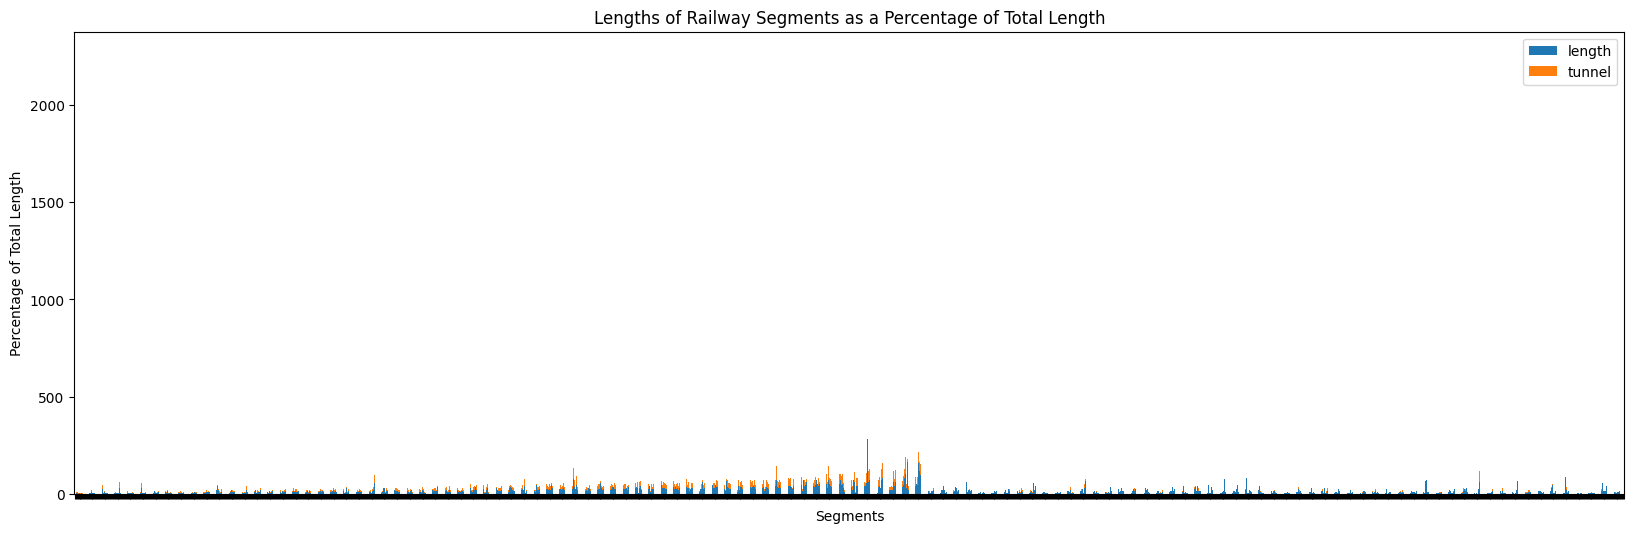

In [33]:
ax = df_type.plot.bar(stacked=True)

plt.xlabel('Segments')
plt.ylabel('Percentage of Total Length')
plt.title('Lengths of Railway Segments as a Percentage of Total Length')

fig = plt.gcf()
fig.set_size_inches(20, 6)
ax.set_xticklabels([])

plt.show()

It looks as though some of the values might not sum to the total length provided in the dataframe. We can see this because the peaks for the tunnel (orange) bars exceed the adjacent lenth (blue) values. I'll implement a check to verify that the length is representative of the values provided by at_grade,elevated, and tunnel.

Lets first check to see how many rows contain a mismatch between the total length and the sum of the length components

In [34]:
total_length = df[['at_grade', 'tunnel', 'elevated']].sum(axis=1)

In [35]:
result = np.where(df['length'] != total_length)

In [36]:
len(result[0])

175

The above print shows that 174 samples in my dataset contain instances where the total length does not equal the sum of the components. This is somewhat expected as we've only cleaned the tunnel portion of the data thus far. Many of these instances are the result of missing data that we had turned from NaNs to 0s in the last step.

Lets also check if the calculation of tunnel length is accurate relative to the total length

### Verifying Tunnel Length Calculation

In [37]:
result = np.where(df['tunnel_per']*df['length'] != df['tunnel'])

In [38]:
len(result[0])

356

This shows that there are 357 results where tunnel length != length * tunnel_per. Let's check how drastic that difference is

In [39]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']

In [40]:
df['diff']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1667    0.0
1668    0.0
1669    0.0
1670    0.0
1671    0.0
Name: diff, Length: 1672, dtype: float64

In [41]:
df['diff'].describe()

count    1672.000000
mean       -0.000018
std         0.001448
min        -0.033920
25%         0.000000
50%         0.000000
75%         0.000000
max         0.028621
Name: diff, dtype: float64

This shows that there are a few outliers in the data producing an offset. The vast majority of the data are within a rounding error and can be ignored, but we'll need to correct the outliers before proceeding.

In [42]:
rows_with_min_value = df[df['diff'] <=-.03]

In [43]:
rows_with_min_value

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
1030,US,Washington,1994,1998,0.0,2.5,1.0,2.53392,0.0,0.0,...,96.218112,0.0,0.0,1,1.739617,424.134396,167.38268,MRT,Extension,-0.03392


This row appears to have mistyped tunnel component, I'll fix this and then check if there are outliers again.

In [44]:
df.loc[1030]

country                    US
city               Washington
start_year               1994
end_year                 1998
rr?                       0.0
length                    2.5
tunnel_per                1.0
tunnel                2.53392
elevated                  0.0
at_grade                  0.0
stations                  1.0
platform_len              NaN
max_speed                95.0
track_gauge              1429
overhead?                   1
cost               243.809042
currency                  USD
year                     1996
ppp_rate                  1.0
cost_real          243.809042
cost_km             96.218112
c_length                  0.0
c_tunnel                  0.0
anglo                       1
inflation_index      1.739617
cost_real_2023     424.134396
cost_km_2023        167.38268
train_type                MRT
project_type        Extension
diff                 -0.03392
Name: 1030, dtype: object

In [45]:
df.loc[1030, 'tunnel'] = 2.5

Let's proceed with correcting all instances of a misprint of 1 instead of 100

In [46]:
result = df.loc[df['tunnel_per'] == 1]

In [47]:
result

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
1,DE,Berlin,1968,1974,0.0,1.500000,1.0,1.500000,0.0,0.0,...,31.001909,0.000000,0.000000,0,6.739406,3.134017e+02,208.934443,MRT,Extension,0.0
2,CN,Beijing,2007,2013,0.0,4.447000,1.0,4.447000,0.0,0.0,...,322.932698,0.000000,0.000000,0,1.251724,1.797578e+03,404.222616,MRT,Extension,0.0
3,CN,Beijing,2019,2021,0.0,3.600000,1.0,3.600000,0.0,0.0,...,191.448979,0.000000,0.000000,0,1.054615,7.268578e+02,201.904944,MRT,New,0.0
4,FR,Lyon,2005,2007,0.0,1.000000,1.0,1.000000,0.0,0.0,...,59.234754,0.000000,0.000000,0,1.353898,8.019784e+01,80.197844,MRT,Extension,0.0
5,BG,Sofia,2012,2016,0.0,1.300000,1.0,1.300000,0.0,0.0,...,47.638348,1.300000,1.300000,0,1.152955,7.140233e+01,54.924867,MRT,Extension,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,BY,Minsk,2014,2023,0.0,17.200000,1.0,17.200000,0.0,0.0,...,113757.424400,0.000000,0.000000,0,1.067626,2.088946e+06,121450.327800,Tramway,New,0.0
1610,BY,Minsk,2012,2014,0.0,5.000000,1.0,5.000000,0.0,0.0,...,1334.513514,0.000000,0.000000,0,1.171658,7.817967e+03,1563.593442,Tramway,Extension,0.0
1636,US,Washington,2006,2010,0.0,3.704096,1.0,3.704096,0.0,0.0,...,354.472445,0.000000,0.000000,1,1.267729,1.664529e+03,449.375126,MRT,New,0.0
1647,IT,Naples,2021,2025,0.0,12.060493,1.0,12.060493,0.0,0.0,...,105.398005,12.060493,12.060493,0,1.000000,1.271152e+03,105.398005,MRT,New,0.0


In [48]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1672.000000
mean        0.000002
std         0.001187
min        -0.028456
25%         0.000000
50%         0.000000
75%         0.000000
max         0.028621
Name: diff, dtype: float64

Now that we've corrected the tunnel length calculation, we need to address the difference between calculated and stated values. It appears the line is missing an at-grade portion of the length.

Within the sources provided with that datapoint, it appears that the remaining length is supposed to be attributed to elevated track. I'll allocate the remaining length to the elevated feature.

In [49]:
df.sort_values(by='diff', ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
1008,US,San Francisco,1997,2003,0.0,13.9,0.670000,9.284379,2.211616,2.424148,...,110.381254,0.0,0.0,1,1.585052,2424.470286,174.960014,MRT,Extension,0.028621
1029,US,Washington,1993,1999,0.0,4.7,1.000000,4.688210,0.000000,0.000000,...,127.034144,0.0,0.0,1,1.739617,1036.051230,220.990779,MRT,Extension,0.011790
952,US,Los Angeles,2004,2009,0.0,9.7,0.280000,2.704800,0.386400,6.568800,...,91.821946,0.0,0.0,1,1.316404,1167.650758,120.874820,Light Rail,Extension,0.011200
1619,US,Pittsburgh,2001,2004,0.0,8.8,0.321107,2.816280,2.611981,3.342275,...,33.654728,0.0,0.0,1,1.483402,437.855714,49.923484,Light Rail,Extension,0.009461
954,US,Los Angeles,2000,2003,0.0,22.1,0.045351,1.000000,1.600000,19.450000,...,32.698413,0.0,0.0,1,1.517209,1093.907829,49.610332,Light Rail,New,0.002268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,US,Denver,1997,2000,1.0,13.6,0.133193,1.814909,11.327631,0.483610,...,12.989730,0.0,0.0,1,1.638331,289.984576,21.281476,Light Rail,New,-0.003483
996,US,Portland,1993,1998,0.0,28.5,0.170000,4.852427,0.000000,23.779700,...,33.947958,0.0,0.0,1,1.739617,1685.689038,59.056451,Light Rail,Extension,-0.007427
1352,US,Miami,1979,1985,0.0,33.8,0.976190,33.005000,0.805000,0.000000,...,29.192547,0.0,0.0,1,2.828455,2791.685357,82.569812,MRT,New,-0.009762
991,US,Pittsburgh,2006,2012,0.0,1.9,0.430000,0.830760,1.101240,0.000000,...,263.975155,0.0,0.0,1,1.272256,648.850438,335.843912,MRT,Extension,-0.013760


Now our errors are within reason. Let's do one more pass to evaluate why the min and max in the above summary are there.

In [50]:
df.loc[1008, 'length'] = (df.loc[1008, 'tunnel']+df.loc[1008, 'elevated'] + df.loc[1008, 'at_grade'])

In [51]:
df.loc[1031, 'tunnel_per'] = (df.loc[1031, 'tunnel']/df.loc[1031, 'length'])

These remaining values all have similar errors in that the calculated length and described length don't match up and they contain missing values for the other portions of the track types. Since we have more detailed values for tunnel length, I'll correct the tunnel_per value.

It was important to individually validate the values before we apply the calculation to the rest of the tunnel values. This should reduce the difference between the calculated tunnel length and the stated tunnel length to zero.

In [52]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1672.000000
mean        0.000027
std         0.001223
min        -0.013760
25%         0.000000
50%         0.000000
75%         0.000000
max         0.042116
Name: diff, dtype: float64

 To complete this section, let's standardize the tunnel calculation. Since we've resolved all other issues except recalculating the tunnel length, this is our final step. Doing this step last ensures that we aren't carrying any other issues into this step.

In [53]:
df[df['diff']<0].sort_values(by='diff')

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
991,US,Pittsburgh,2006,2012,0.0,1.90,0.430000,0.830760,1.101240,0.000000,...,263.975155,0.0,0.00,1,1.272256,648.850438,335.843912,MRT,Extension,-1.376000e-02
1352,US,Miami,1979,1985,0.0,33.80,0.976190,33.005000,0.805000,0.000000,...,29.192547,0.0,0.00,1,2.828455,2791.685357,82.569812,MRT,New,-9.761904e-03
996,US,Portland,1993,1998,0.0,28.50,0.170000,4.852427,0.000000,23.779700,...,33.947958,0.0,0.00,1,1.739617,1685.689038,59.056451,Light Rail,Extension,-7.427300e-03
1070,US,Denver,1997,2000,1.0,13.60,0.133193,1.814909,11.327631,0.483610,...,12.989730,0.0,0.00,1,1.638331,289.984576,21.281476,Light Rail,New,-3.482949e-03
1013,US,Seattle,2003,2009,0.0,25.10,0.150000,3.766500,0.000000,21.343500,...,101.871764,0.0,0.00,1,1.353898,3463.272318,137.924027,Light Rail,New,-1.500000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,US,Washington,1995,2001,0.0,10.70,0.702659,7.518456,3.224574,0.000000,...,79.170049,0.0,0.00,1,1.674515,1423.903520,132.571429,MRT,Extension,-8.881784e-16
1660,KR,Busan,2003,2011,0.0,12.70,0.600000,7.620000,4.023350,1.043000,...,127.810735,12.7,7.62,0,1.316404,2136.782893,168.250621,MRT,New,-8.881784e-16
1081,CA,Calgary,2008,2012,0.0,8.20,0.290000,2.378000,1.448406,4.373594,...,136.341986,0.0,0.00,1,1.251724,1399.432829,170.662540,Light Rail,Extension,-4.440892e-16
1534,RO,Bucharest,2008,2020,0.0,6.60,0.530000,3.498000,3.102000,0.000000,...,112.390419,0.0,0.00,0,1.152955,855.235166,129.581086,MRT,New,-4.440892e-16


In [54]:
df['tunnel'] = (df['tunnel_per'] * df['length'])

In [55]:
df.sort_values(by='tunnel', ascending=True)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
0,HK,Hong Kong,2000,2005,0.0,1.30000,0.000000,0.000,1.3,0.00000,...,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension,0.000000e+00
1134,UK,Birmingham,2021,2026,0.0,1.68511,0.000000,0.000,0.0,1.68511,...,198.606568,0.0,0.0,1,0.984983,329.648051,195.624012,Light Rail,Extension,0.000000e+00
1135,UK,Birmingham,1995,2002,0.0,21.00000,0.000000,0.000,0.0,21.00000,...,9.513063,0.0,0.0,1,1.638331,327.296455,15.585545,Tramway,New,0.000000e+00
1136,UK,Birmingham,2019,2022,0.0,1.93121,0.000000,0.000,0.0,1.93121,...,103.308260,0.0,0.0,1,1.007292,200.964786,104.061592,Tramway,New,0.000000e+00
1137,UK,Birmingham,2021,2025,0.0,10.94350,0.000000,0.000,0.0,10.94350,...,73.772340,0.0,0.0,1,1.000000,807.327599,73.772340,Tramway,New,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,CN,Ningbo,2013,2020,0.0,100.10000,0.900000,90.090,5.1,4.91000,...,152.913274,0.0,0.0,0,1.113520,17044.220620,170.271934,MRT,New,0.000000e+00
821,CN,Yiwu,2020,2025,0.0,107.17000,0.900000,96.453,0.0,10.71700,...,80.466653,0.0,0.0,0,1.000000,8623.611185,80.466653,MRT,New,0.000000e+00
906,CN,Guangzhou,2020,2025,1.0,107.00000,1.000000,107.000,0.0,0.00000,...,221.453034,0.0,0.0,0,1.000000,23695.474610,221.453034,MRT,New,0.000000e+00
915,QA,Doha,2013,2026,0.0,124.00000,0.899194,111.500,6.0,6.50000,...,521.677031,0.0,0.0,0,1.054615,68220.877170,550.168364,Light Rail,New,1.600000e-09


In [56]:
df['diff'] = (df['tunnel_per'] * df['length']) - df['tunnel']
df['diff'].describe()

count    1672.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: diff, dtype: float64

### Missing Length Components

Within the dataset, there is a large subset of values that has a total length and a tunnel length, but don't have values for at grade or elevated. We'll need to devise a way to determine how to populate these rows with data that is representative of the total dataset and within reason given the application of the data.

We'll look at each iteration to evaluate the best way to populate these missing values

In [57]:
rows_miss = df[((df['elevated'] == 0.0) & (df['at_grade'] == 0.0) & (df['tunnel_per'] ==0))]

In [58]:
rows_miss

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff


The above output shows that there are no missing length components in the dataset. In this version of the notebook, I've gone ahead and corrected the mistakes in the csv file before importing it into the notebook in v2.

In [59]:
df['diff'] = (df['length'] - (df['at_grade']) - (df['elevated']) - (df['tunnel']))
df['diff'].describe()

count    1672.000000
mean        0.002754
std         0.101532
min        -0.124700
25%         0.000000
50%         0.000000
75%         0.000000
max         4.140000
Name: diff, dtype: float64

In [60]:
df.sort_values(by='diff', ascending=False)

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,diff
1419,PT,Porto,2023,2026,0.0,6.74,0.385757,2.600000,0.000000,0.000000,...,101.382500,6.740,2.6,0,0.970410,663.098366,98.382547,Tramway,New,4.140000
1009,US,San Francisco,2010,2014,0.0,5.20,0.046584,0.242236,4.300000,0.600000,...,93.944099,0.000,0.0,1,1.188820,575.388869,111.682622,APM,Extension,0.057764
936,US,Denver,2008,2013,0.0,19.50,0.000000,0.000000,2.300000,17.143280,...,37.729069,0.000,0.0,1,1.213422,891.865179,45.781283,Light Rail,New,0.056720
925,US,Charlotte,2005,2007,0.0,15.50,0.000000,0.000000,0.000000,15.450000,...,29.967638,0.000,0.0,1,1.353898,626.854997,40.573139,Light Rail,New,0.050000
1079,KR,Daegu,2009,2015,0.0,24.00,0.000000,0.000000,23.950000,0.000000,...,41.944756,23.950,0.0,0,1.188820,1194.261086,49.864764,Monorail,New,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,US,Sacramento,1999,2003,0.0,10.10,0.000000,0.000000,0.198201,9.944799,...,22.084196,0.000,0.0,1,1.541197,345.228059,34.036090,Light Rail,Extension,-0.043000
1080,KR,Yongin,2005,2013,0.0,18.10,0.000000,0.000000,18.143000,0.000000,...,48.436333,18.143,0.0,0,1.272256,1118.033420,61.623404,MRT,New,-0.043000
1031,US,Washington,1995,2001,0.0,10.70,0.702659,7.518456,3.224574,0.000000,...,79.170049,0.000,0.0,1,1.674515,1423.903520,132.571429,MRT,Extension,-0.043030
943,US,Hudson County,2000,2011,0.0,27.40,0.050000,1.370000,2.300000,23.812200,...,80.291971,0.000,0.0,1,1.353898,2978.576661,108.707177,Light Rail,New,-0.082200


#### Final Length Component Features

Now we have a dataframe that contains complete features pertaining to the breakdown of track type/lengths. As shown in the dataframe above, there are still several values where the difference between length and the sum of the length components is non-zero. I have decided that this is a reasonable approximation of the length components and I will move forward with this set of data. 

My reasoning is that:

1) Many of the samples are still under construction and some are in the early stages of construction. The overall length component shown in the dataset is itself an approximation and so it's reasonable to accept small discrepancies in price
2) The purpose of this analysis is to *approximate* the overall cost of a project given some parameters. We're not interested in identifying a specific number and this level of error is within reason given the application
3) Further tuning the length components could introduce more error than leaving them as is. With the remaining rows containing error shown above, there aren't clear sources that identify which components I should adjust.


Further cleaning will be completed regarding other features, however the cleaning pertaining to the length components is complete.

In [61]:
df = df.drop(columns = 'diff')

### Remaining Cleaning

In [62]:
nan_counts = df.isna().sum()
print(nan_counts)

country               0
city                  0
start_year            0
end_year              0
rr?                   2
length                0
tunnel_per            0
tunnel                0
elevated              0
at_grade              0
stations             20
platform_len       1232
max_speed             0
track_gauge           0
overhead?             0
cost                  0
currency              0
year                  0
ppp_rate              0
cost_real             0
cost_km               0
c_length              0
c_tunnel              0
anglo                 0
inflation_index       0
cost_real_2023        0
cost_km_2023          0
train_type            0
project_type          0
dtype: int64


As we see above, there are 3 features that we can clean. I'll address them individually below

#### Railroads (rr?)

This feature is meant to indicate if the track used by the passenger line is shared with a freight line

There are two missing values, let's look at them and identify if we can supplement the dataset

In [63]:
df[df['rr?'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
506,IN,Pune,2018,2021,NaN,23.3,0.0,0.0,23.3,0.0,...,3781.06600,162.277511,0.0,0.0,0,1.054615,3987.568501,171.140279,MRT,New
913,SA,Mecca,2009,2024,NaN,188.0,0.1,18.8,18.8,150.4,...,37597.92896,199.988984,0.0,0.0,0,1.113520,41866.032310,222.691661,Light Rail,New


For the first row above, the railway in question appears to be a railroad line. This is for a few reasons:

1) The railway is elevated throughout, however several stations are adjacent to cargo rail yards. I'd expect a cargo rail line to connect to a hub within a major city, however an elevated track within a city is unusual. 
2) The source noted for this row includes information regarding a line extension to a potential cargo hub within the same city. It's unlikely that passenger trains would need a way to get to a train yard that's meant for cargo unless the tracks were serving both uses.

For the second row above, the railway in question appears to be a railroad line:
1) The length of the line is 188km and the rail line is not a high speed route. Given the length of the line and based on the images seen on google maps, I believe the passenger line intersects a cargo route outside of the city center


In [64]:
df.loc[506, 'rr?'] = 1
df.loc[913, 'rr?'] = 1

#### Stations

This feature is meant to denotate the number of stations for each line. This is a tremendously valuable feature as the cost to build stations is a relevant factor in the overall cost of a network. There are 20 missing values and so we'll evaluate them 1 by 1.

In [65]:
df[df['stations'].isna()]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
133,CN,Shanghai,2009,2012,0.0,5.372,1.000000,5.372,0.000,0.000,...,794.446140,147.886474,0.0,0.0,0,1.213422,963.998435,179.448703,MRT,New
196,JP,Tokyo,2015,2025,1.0,3.000,0.000000,0.000,3.000,0.000,...,1069.046752,356.348917,0.0,0.0,0,1.054615,1127.432622,375.810874,Monorail,Extension
296,CN,Guangzhou,2009,2016,0.0,17.600,1.000000,17.600,0.000,0.000,...,1953.246016,110.979887,0.0,0.0,0,1.171658,2288.536332,130.030473,MRT,Extension
324,CN,Guangzhou,2009,2017,0.0,18.300,1.000000,18.300,0.000,0.000,...,2115.379629,115.594515,0.0,0.0,0,1.171658,2478.501477,135.437239,MRT,New
339,CN,Shenzhen,2020,2025,0.0,4.260,1.000000,4.260,0.000,0.000,...,2068.194731,485.491721,0.0,0.0,0,1.000000,2068.194731,485.491721,MRT,Extension
368,KR,Seoul,2018,2025,1.0,42.600,1.000000,42.600,0.000,0.000,...,15626.112370,366.810149,42.6,42.6,0,1.015482,15868.042370,372.489258,MRT,Extension
375,CN,Guangzhou,2012,2019,0.0,17.600,1.000000,17.600,0.000,0.000,...,2313.957677,131.474868,0.0,0.0,0,1.137242,2631.528829,149.518684,MRT,New
379,CN,Shanghai,1997,2000,0.0,24.975,0.000000,0.000,21.605,3.375,...,3437.852153,137.651738,0.0,0.0,0,1.638331,5632.339538,225.519101,MRT,New
398,EG,Cairo,2019,2025,0.0,19.000,1.000000,19.000,0.000,0.000,...,170.858847,8.992571,0.0,0.0,0,1.015482,173.504155,9.131798,MRT,New
501,CN,Putian,2020,2025,1.0,23.800,0.626050,14.900,8.900,0.000,...,3364.110929,141.349199,0.0,0.0,0,1.000000,3364.110929,141.349199,MRT,New


The first thing I notice is that a few of the lines are short and are extensions of an existing line. It's possible that some of them may be extensions between existing stations.

Because of this, let's create several lists of indices to keep track.

In [66]:
no_station = [196]
one_station = [133]
two_station = [368]
four_station = [906]
seven_station =[339,375,871]
eight_station = [815]
ten_station = [296,324,398,501]
thirteen_station = [618]
eigteen_station = [656, 800, 908]
nineteen_station = [379]
twentysix_station = [880]
fifty_four = [859,915]

In [67]:
df.loc[no_station, 'stations'] = 0
df.loc[one_station, 'stations'] = 1
df.loc[two_station, 'stations'] = 2
df.loc[four_station, 'stations'] = 4
df.loc[seven_station, 'stations'] = 7
df.loc[eight_station, 'stations'] = 8
df.loc[ten_station, 'stations'] = 10
df.loc[thirteen_station, 'stations'] = 13
df.loc[eigteen_station, 'stations'] = 18
df.loc[nineteen_station, 'stations'] = 19
df.loc[twentysix_station, 'stations'] = 26
df.loc[fifty_four, 'stations'] = 54

#### Platform Length (platform_len)

This feature represents the length of each platform at each station. Because there are so many missing values, I'll remove this feature entirely.

In [68]:
df = df.drop(columns = 'platform_len')

In [69]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_real,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,3122.576663,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,46.502863,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,1436.081706,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,689.216325,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,59.234754,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,217.028161,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New
1668,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,6.146051,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension
1669,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,206.893990,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New
1670,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,2172.174214,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New


### Checking Start/End Years

In [70]:
df['end_year'] = df['end_year'].astype(int)
df['start_year'] = df['start_year'].astype(int)

In [71]:
df['duration'] = df['end_year']-df['start_year']

In [72]:
df['duration'].sort_values(ascending=False)

316     27
89      24
912     24
809     23
1027    22
        ..
1624     1
874      1
1175     1
765     -4
1572    -9
Name: duration, Length: 1672, dtype: int64

There are a few rows where the start and end dates appear to have been flipped

In [73]:
df[df['duration'] < 0]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,duration
765,CN,Shenzhen,2020,2016,0.0,30.2,1.0,30.2,0.0,0.0,...,210.426132,0.0,0.0,0,1.086971,6907.556151,228.727025,MRT,New,-4
1572,TW,Taipei,2023,2014,0.0,8.5,0.0,0.0,0.0,8.5,...,845.642846,0.0,0.0,0,1.067626,7674.053910,902.829872,MRT,Extension,-9


In [74]:
df.loc[275, 'start_year'] = 2016
df.loc[275, 'end_year'] = 2020

df.loc[765, 'start_year'] = 2016
df.loc[765, 'end_year'] = 2020

df.loc[1342, 'start_year'] = 2012
df.loc[1342, 'end_year'] = 2014

df.loc[1440, 'start_year'] = 2015
df.loc[1440, 'end_year'] = 2018

df.loc[1572, 'start_year'] = 2014
df.loc[1572, 'end_year'] = 2023

df.loc[1635, 'start_year'] = 2009
df.loc[1635, 'end_year'] = 2017

In [75]:
df['duration'] = df['end_year']-df['start_year']
df[df['duration'] < 0]

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,duration


We've resolved this minor error in the data by swapping the start and end years for the 2 rows above.

In [76]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

df['cost_real_2023'] = df['cost_real_2023'].apply(convert_str_to_float)

In [77]:
df.isna().sum()

country            0
city               0
start_year         0
end_year           0
rr?                0
length             0
tunnel_per         0
tunnel             0
elevated           0
at_grade           0
stations           0
max_speed          0
track_gauge        0
overhead?          0
cost               0
currency           0
year               0
ppp_rate           0
cost_real          0
cost_km            0
c_length           0
c_tunnel           0
anglo              0
inflation_index    0
cost_real_2023     0
cost_km_2023       0
train_type         0
project_type       0
duration           0
dtype: int64

### Train Type Cleaning

Within the Train Type category, the category 'Regional Rail' is significantly different from the rest of the data to warrant removing these datapoints entirely.

These proejects, while terminating within metropolitan areas, do not require the same level of service that metro projects would entail and don't have the same type of contraints of a passenger rail service that operates within a urban area.

In [78]:
df = df[df['train_type']!='Regional Rail']
df = df[df['train_type']!='Commuter Rail']

In [79]:
df['train_type'].value_counts()

MRT           1003
Light Rail     259
Tramway        249
Monorail        50
Streetcar       38
APM             14
Tram             1
Name: train_type, dtype: int64

In [80]:
df

,country,city,start_year,end_year,rr?,length,tunnel_per,tunnel,elevated,at_grade,...,cost_km,c_length,c_tunnel,anglo,inflation_index,cost_real_2023,cost_km_2023,train_type,project_type,duration
0,HK,Hong Kong,2000,2005,0.0,1.300,0.0,0.000,1.3,0.0,...,2401.982049,0.0,0.0,0,1.483402,4632.035892,3563.104532,MRT,Extension,5
1,DE,Berlin,1968,1974,0.0,1.500,1.0,1.500,0.0,0.0,...,31.001909,0.0,0.0,0,6.739406,313.401664,208.934443,MRT,Extension,6
2,CN,Beijing,2007,2013,0.0,4.447,1.0,4.447,0.0,0.0,...,322.932698,0.0,0.0,0,1.251724,1797.577974,404.222616,MRT,Extension,6
3,CN,Beijing,2019,2021,0.0,3.600,1.0,3.600,0.0,0.0,...,191.448979,0.0,0.0,0,1.054615,726.857798,201.904944,MRT,New,2
4,FR,Lyon,2005,2007,0.0,1.000,1.0,1.000,0.0,0.0,...,59.234754,0.0,0.0,0,1.353898,80.197844,80.197844,MRT,Extension,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,ES,Seville,2024,2026,0.0,1.500,0.0,0.000,0.0,1.5,...,144.685441,1.5,0.0,0,0.970410,210.606202,140.404135,Light Rail,New,2
1668,NZ,Christchurch,2021,2022,0.0,0.500,0.0,0.000,0.0,0.5,...,12.292101,0.0,0.0,1,1.015482,6.241206,12.482413,Tramway,Extension,1
1669,AU,Canberra,2023,2026,0.0,1.700,0.0,0.000,0.0,1.7,...,121.702347,0.0,0.0,1,0.970410,200.771905,118.101121,Light Rail,New,3
1670,CO,Medellin,2023,2027,0.0,13.100,0.0,0.000,0.0,13.1,...,165.814826,0.0,0.0,0,0.970410,2107.898620,160.908292,Tramway,New,4


## Section Conclusion

In this portion of the analysis I made several decisions which changed the structure of the dataset that we will be working with in future sections. I'll summarize those changes below and then pickle the dataframe for use in subsequent sections.

- Before I began work on this section, I did significant work on the base dataset to produce a more complete version of the data.
- This work included filling out missing values with estimates given the best available data for each individual project. There was no way to do this programmatically and so this work was completed outside of python, using wikipedia/chatGPT/online sources to find missing data.
- These sources were not used initially by the project team that produced the dataset because these sources are not official. I opted to use these sources because they represented the best known estimate, which is within reason given the application of this anaylsis.
- This altered dataset was imported into this notebook where I continued to validate the data.
- Much of this validation was spent ensuring that the length components made sense for each project
- Several features were dropped from the dataset as they either posed no discernible value or they contained too many missing values that I could not estimate myself.
- The resultant dataset represents a fair estimate of the cost and characteristics of each project given in the initial dataset.

In [81]:
df_cleaned = df

### Exporting Dataframe

In [82]:
with open('pickles/df.pkl', 'wb') as f:
    pickle.dump(df, f)
with open('pickles/df_base.pkl', 'wb') as f:
    pickle.dump(df_base, f)
with open('pickles/df_cleaned.pkl', 'wb') as f:
    pickle.dump(df_cleaned, f)

In [83]:
df.shape

(1614, 29)